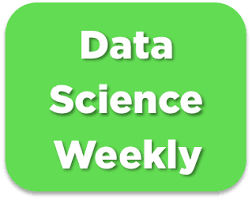

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
!pip install plotly
!pip install seaborn
!pip install mlxtend
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('src/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [5]:
data_sample.describe()

,age,new_user,total_pages_visited,converted
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,30.440700,0.690100,4.929100,0.032400
std,8.220647,0.462475,3.363511,0.177069
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,65.000000,1.000000,28.000000,1.000000


In [6]:
data.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.011676,-0.045365,-0.088265
new_user,0.011676,1.000000,-0.082986,-0.152115
total_pages_visited,-0.045365,-0.082986,1.000000,0.529192
converted,-0.088265,-0.152115,0.529192,1.000000


<AxesSubplot:xlabel='age', ylabel='countconverted'>

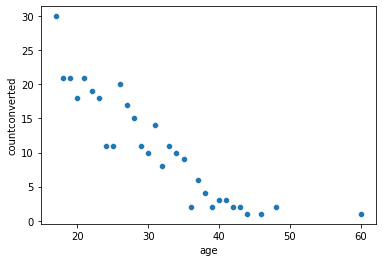

In [7]:
mask= (data_sample["converted"]==1)
gr= data_sample[mask].groupby("age").agg(
    countconverted=pd.NamedAgg(column="converted", aggfunc="count")).reset_index()

sns.scatterplot(data=gr, x="age", y="countconverted")

<AxesSubplot:xlabel='age', ylabel='countconverted'>

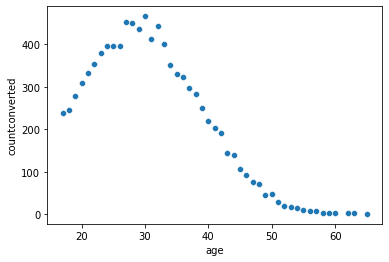

In [8]:
mask= (data_sample["converted"]==0)
gr= data_sample[mask].groupby("age").agg(
    countconverted=pd.NamedAgg(column="converted", aggfunc="count")).reset_index()

sns.scatterplot(data=gr, x="age", y="countconverted")

<AxesSubplot:xlabel='country', ylabel='countconverted'>

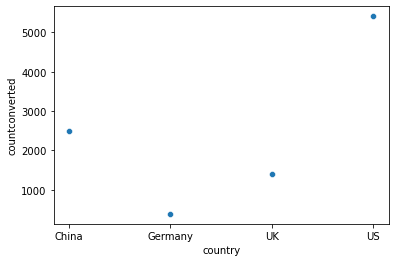

In [9]:
mask= (data_sample["converted"]==0)
gr= data_sample[mask].groupby("country").agg(
    countconverted=pd.NamedAgg(column="converted", aggfunc="count")).reset_index()

sns.scatterplot(data=gr, x="country", y="countconverted")

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [10]:
features_list = ['total_pages_visited','new_user','age']
numeric_indices = [0,1,2]
categorical_indices = []
target_variable = 'converted'

In [11]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited', 'new_user', 'age'], dtype='object')



In [12]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y )
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [13]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[ 2  0 23]
 [ 2  0 28]
 [ 7  1 30]
 [ 3  1 37]
 [ 8  1 31]]
[[14  1 24]
 [ 5  0 35]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [14]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.85939501 -1.4767432  -0.91458053]
 [-0.85939501 -1.4767432  -0.30994956]
 [ 0.63639894  0.67716581 -0.06809718]
 [-0.56023622  0.67716581  0.77838618]
 [ 0.93555773  0.67716581  0.05282902]]


In [15]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [16]:
""""print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)"""

'"print("Grid search...")\nclassifier = RandomForestClassifier()\n\n# Grid of values to be tested\nparams = {\n    \'max_depth\': [2, 4, 6, 8, 10],\n    \'min_samples_leaf\': [1, 2, 5],\n    \'min_samples_split\': [2, 4, 8],\n    \'n_estimators\': [10, 20, 40, 60, 80, 100]\n}\ngridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV\ngridsearch.fit(X_train, Y_train)\nprint("Best hyperparameters : ", gridsearch.best_params_)\nprint("Best validation accuracy : ", gridsearch.best_score_)'

In [17]:
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [ 6],
    'min_samples_leaf': [5],
    'min_samples_split': [8],
    'n_estimators': [80]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 80}
Best validation accuracy :  0.9851594162157097


In [18]:
#Grid search...
#Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 80}
#Best validation accuracy :  0.9851477030477662

In [19]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [20]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 2.73051047  0.67716581 -0.79365434]
 [ 0.03808136 -1.4767432   0.53653379]
 [-0.26107743 -1.4767432  -0.18902337]
 [ 0.93555773  0.67716581  0.05282902]
 [-0.85939501  0.67716581 -0.30994956]]


In [21]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [22]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7466774063632703
f1-score on test set :  0.740785498489426


In [23]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246786   1074]
 [  2700   5562]]

Confusion matrix on test set : 
[[27416   124]
 [  305   613]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [24]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RandomForestClassifier()

In [25]:
# Read data without labels
data_without_labels = pd.read_csv('src/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited','new_user','age']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16  0 28]
 [ 5  1 22]
 [ 1  1 32]
 [ 6  1 32]
 [ 3  0 25]]


In [26]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32882805 -1.4767432  -0.30994956]
 [ 0.03808136  0.67716581 -1.03550673]
 [-1.1585538   0.67716581  0.17375521]
 [ 0.33724015  0.67716581  0.17375521]
 [-0.56023622 -1.4767432  -0.67272814]]


In [27]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**